## Numpy-имплементация многослойной нейронной сети

**Вариант:** 14

**Цель работы:** реализовать нейронную сеть и обучить ее с помощью метода обратного распространения ошибки.

**Задачи:**
* реализовать нейронную сеть на основе numpy;
* обучить созданную нейронную сеть.

In [23]:
import numpy as np

Сначала определим базовый класс Layer с основными методами .forward() и .backward().

In [24]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # An identity layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### ReLu слой

ReLU — это нелинейная функция активации, которая используется для сверточных нейронных сетей и глубокого обучения для всех слоев, кроме выходного.

In [25]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        output = np.maximum(0, input)
        return output
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = input > 0
        return grad_output * relu_grad_mask    

### Функция численного подсчета градиентов

In [26]:
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/ (our ysda course).
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad



import sys
import os
import time

import numpy as np

def load_mnist(flatten=False):
    """taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0],-1])
        X_val = X_val.reshape([X_val.shape[0],-1])
        X_test = X_test.reshape([X_test.shape[0],-1])

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

import matplotlib.pyplot as plt
def plot_embedding(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])

### Tестирование градиентов

In [27]:
points = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(points, np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=points)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Полносвязный слой

Полносвязный слой — слой, выходные нейроны которого связаны со всеми входными нейронами. Нейроном в данном случае называется математическая модель искуственного нейрона.

In [30]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.sum(axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Тестирование полносвязного слоя

In [31]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [35]:
x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [36]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### Функция потерь

In [37]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [38]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Итоговая нейросеть

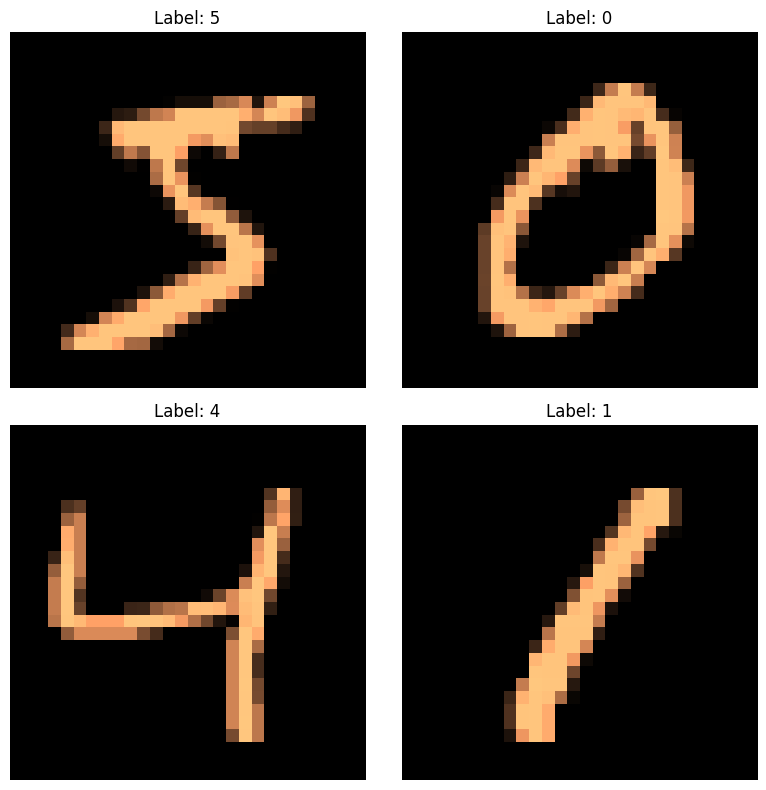

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[8,8])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28,28]), cmap='copper')
    plt.axis('off')  
plt.tight_layout()  
plt.show()


### Сеть

In [51]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

### Прямой проход по сети

In [52]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)


In [53]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
        
    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates

    return np.mean(loss)

Точность классификации на валидационном множестве должна превысить 97%

In [54]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [55]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 14
Train accuracy: 0.9874
Val accuracy: 0.9689


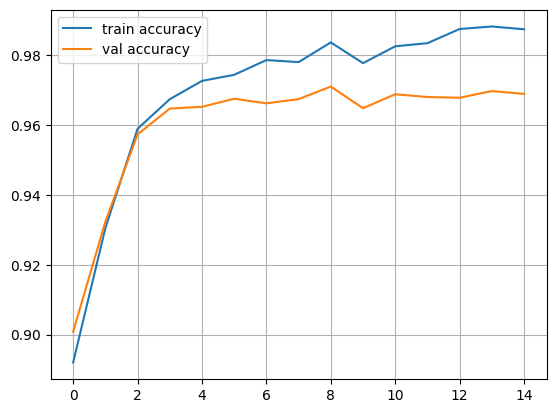

In [56]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

### Визуализация

Векторы активаций нейронов с одного из последних слоев

In [59]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]

In [60]:
from sklearn.manifold import TSNE
subset_ids = np.random.permutation(X_train.shape[0])[:1000]

x_original = X_train[subset_ids]
x_learnt = train_hidden_representations[subset_ids]
x_original_tsne = TSNE(n_components=2).fit_transform(x_original)
x_learnt_tsne = TSNE(n_components=2).fit_transform(x_learnt)

Исходный набор

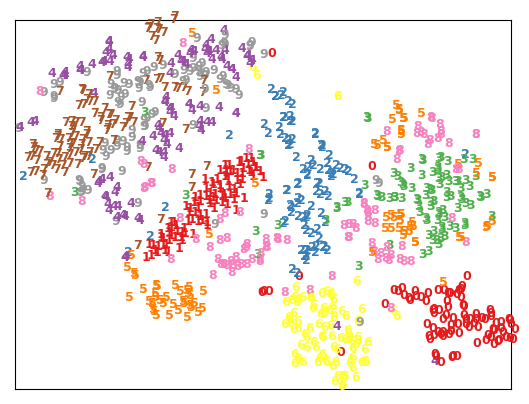

In [63]:
plot_embedding(x_original_tsne, y_train[subset_ids])

Тренировочный набор

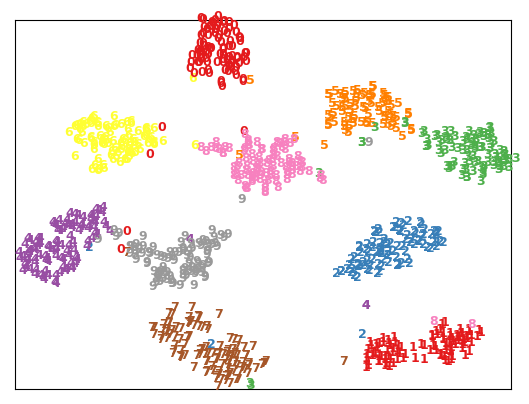

In [64]:
plot_embedding(x_learnt_tsne, y_train[subset_ids])

### Предсказание четности изображенной цифры

In [65]:
new_y_train = y_train % 2
new_y_test = y_test % 2

In [66]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs")


# Использование обученных представлений для тренировочного и тестового набора
train_repr = train_hidden_representations
test_repr = test_hidden_representations

lr.fit(train_repr, new_y_train)

# Оценка точности на тестовом наборе
accuracy = lr.score(test_repr, new_y_test)
print(f"Accuracy of parity prediction: {accuracy}")

Accuracy of parity prediction: 0.9509


C:\Users\Dns\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Точность равна 0.9509, что означает, что модель правильно классифицирует паритет данных в 95.09% случаев. Модель успешно обобщает свои знания и способна делать точные предсказания на новых данных, которые она ранее не видела. Таким образом, можно сделать вывод о том, что обученные представления обладают высокой универсальностью и способны к обобщению.

### Контрольные вопросы

1. Биологический и искусственный нейрон. Основные функции активации нейронов.

**Биологический нейрон:** Это основная единица нервной системы животных и человека. Он состоит из тела клетки, дендритов (получающих входные сигналы), аксона (передающего выходной сигнал) и синапсов (связей между нейронами). Биологический нейрон передает сигналы в виде электрических импульсов, известных как акционные потенциалы.

**Искусственный нейрон:** Это модель, разработанная для имитации биологических нейронов в компьютерных системах. Он имеет входы (аналогичные дендритам), веса (определяющие важность каждого входа), функцию активации (определяющую, активируется ли нейрон) и выход (аналогичный аксону).

**Основные функции активации нейронов:**

* Сигмоидальная (логистическая) функция: Применяется в классических нейронных сетях. Преобразует взвешенную сумму входов в диапазон значений между 0 и 1.
* Гиперболический тангенс (tanh): Применяется в сетях глубокого обучения. Преобразует взвешенную сумму входов в диапазон значений между -1 и 1.
* ReLU (Rectified Linear Unit): Широко используемая функция активации, которая становится активной при положительных входах, а отрицательные входы приводят к значению 0. Позволяет избежать проблемы исчезающего градиента и ускоряет обучение.
* Softmax: Применяется для многоклассовой классификации. Преобразует выходы нейронной сети в вероятности для каждого класса, сумма которых равна 1.

2. Преимущества нейронных сетей.

* Обучение на основе данных: Нейронные сети способны извлекать сложные зависимости из больших объемов данных.
* Автоматическое извлечение признаков: Нейронные сети могут автоматически извлекать признаки из входных данных, не требуя ручной настройки.
* Применение в различных задачах: Нейронные сети могут быть применены для решения широкого спектра задач, включая классификацию, регрессию, обработку изображений и естественного языка.
* Гибкость: Нейронные сети могут быть настроены для решения разнообразных задач, их архитектура может быть изменена в зависимости от конкретной задачи.

3. Классификации нейронных сетей, области применения и решаемые задачи. Основные направления развития нейрокомпьютинга.

**Классификация нейроных сетей:**
* Перцептрон: Применяется для бинарной классификации. 
* Сверточные нейронные сети (CNN): Применяются для анализа изображений. 
* Рекуррентные нейронные сети (RNN): Применяются для анализа последовательных данных, таких как тексты, аудио и временные ряды. 
* Глубокие нейронные сети (DNN): Применяются для решения сложных задач, требующих обработки больших объемов данных. 

**Решаемые задачи:** 
* Классификация. 
* Регрессия. 
* Прогнозирования временных рядов. 
* Кластеризация. 
* Генерация. 

**Основные направления развития нейрокомпьютинга:**
* Глубокое обучение (компьютерное зрение, обработка естественного языка, рекомендательные системы и медицинская диагностика)
* Обучение с подкреплением (создание автономных систем, которые способны принимать решения на основе взаимодействия с окружающей средой)
* Обучение без учителя (извлечение скрытых структур из не размеченных данных) 
* Использование графических процессоров (GPU)
* Разработка новых архитектур нейронных сетей